## Auteur : Amine Djeghri

In [57]:
from bs4 import BeautifulSoup
import gridfs
import time
import os
import wget
import requests
import pymongo
from selenium.common.exceptions import StaleElementReferenceException
from selenium import webdriver
import collections
from bson.binary import Binary
from PIL import Image
import io
import matplotlib.pyplot as plt

# import logins
from src.secrets import username, password, mongo_db, mongo_db_collection, mongo_password, mongo_username

### MongoDB Setup

In [39]:
# MongoDB:
class MongoDBPipeline(object):
    def __init__(self, database_name):
        client = pymongo.MongoClient(
            "mongodb+srv://{}:{}@cluster0.kzqwf.mongodb.net/{}?retryWrites=true&w=majority"
                .format(mongo_username, mongo_password, mongo_db)
        )
        
        if database_name in client.list_database_names():
            self.db = client.get_database(database_name)
            print("connected to the database")
        else: 
            raise Exception("Database doesn't exist")
    
    def get_collection(self, collection_name):
        if collection_name in self.db.list_collection_names():
            print("The collection exists")
            return self.db.collection_name
        else: 
            raise Exception("Collection doesn't exist")
        

mongo_pipeline = MongoDBPipeline("mongo_fb")
text_collection = mongo_pipeline.get_collection("mongo_fb_collection") # text storage
fs_photos = gridfs.GridFS(mongo_pipeline.db,"images") # photos storage

connected to the database
The collection exists


### Classe de Scraping

In [54]:
class FbScraper:
    def __init__(self):
        
        # Options
        options = webdriver.FirefoxOptions()
        options.set_preference("dom.push.enabled", False)
        options.headless = False

        # Login
        self.driver = webdriver.Firefox(options=options, executable_path=r'C:\Users\amine\Downloads\geckodriver-v0.29.1-win64\geckodriver.exe')
        url = 'https://www.facebook.com'
        self.driver.get(url)
        email = self.driver.find_element_by_name("email")
        pswrd = self.driver.find_element_by_name("pass")
        email.send_keys(username)
        pswrd.send_keys(password)
        email.submit()


        self.WAIT_TIME = 5
        time.sleep(self.WAIT_TIME)
        
    def get_posts(self):
        
        # I used a static url for this example
        url = "https://www.facebook.com/search/posts/?q=le%20d%C3%A9c%C3%A8s%20du%20pr%C3%A9sident%20Jacques%20Chirac"
        self.driver.get(url)
        n_scrolls = 2
        key_words= ["posts", "groups", "photos", "videos"]
        for n_scroll in range(n_scrolls):
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)

        links = self.driver.find_elements_by_tag_name('a')
        links = [a.get_attribute('href') for a in links ]    
        links = [a for a in links if (any(k in str(a) for k in key_words)
                                      and "search" not in str(a) and len(str(a))>35)]
        links = links[:5] # MAX Links = 5

        documents =[]
        for i in links:
            document = {}
            self.driver.get(i)
            time.sleep(self.WAIT_TIME)
            content = self.driver.find_elements_by_css_selector('.d2edcug0.hpfvmrgz.qv66sw1b.c1et5uql.lr9zc1uh.a8c37x1j.keod5gw0.nxhoafnm.aigsh9s9.d3f4x2em.fe6kdd0r.mau55g9w.c8b282yb.iv3no6db.jq4qci2q.a3bd9o3v.knj5qynh.oo9gr5id.hzawbc8m')
            print(i) 
            document["url"] = i
            document["text"] = content[0].text # I kept the \n in the texts
            documents.append(document)
        
        return documents
    
    def get_images(self, fs):
    
        url = "https://www.facebook.com/search/photos/?q=le%20d%C3%A9c%C3%A8s%20du%20pr%C3%A9sident%20Jacques%20Chirac&sde=AbrhaiKXDqqu_fb77YjQsO_CebDCRHPLiNE0cOm1PlgsXxM_Rl_Fm5TYgT0k4dwQkIbOcydO76iajnYVjjHe3n2-SPwYuTn2Ih5DeFi2WhC5ZRIRWoIWOMpWE2CX7FDcGyBdEM99soa0mQ34-FMsP2xFALM-eWnwAThwWrSfUH1Wew"
        self.driver.get(url)
        n_scrolls = 2
        key_words= ["photos"]
        
        for n_scroll in range(n_scrolls):
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(self.WAIT_TIME)
            
        links = self.driver.find_elements_by_tag_name('a')
        links = [a.get_attribute('href') for a in links ]    
        links = [a for a in links if (any(k in str(a) for k in key_words)
                                      and "search" not in str(a) and len(str(a))>35)]
        links = links[:5] # MAX Photos = 5
        
        counter = 0
        for i in links:
            print(counter)
            self.driver.get(i)
            time.sleep(self.WAIT_TIME)
            content = self.driver.find_elements_by_css_selector('.gitj76qy.r9f5tntg.d2edcug0.r0294ipz')
            print(i) 
            img = content[0].get_attribute('src')
            print(img)
            request = requests.get(img, stream=True)
            stored = fs.put(request.raw, filename="img_"+str(counter))
            counter += 1
        

In [55]:
fs = FbScraper()

## Test Scraping des posts 
J'ai réduit le nombre de liens = 5

Prend également en compte le texte posté sur les groupes, les photos et les videos

In [5]:
documents = fs.get_posts()

https://www.facebook.com/blm27/posts/2633081830089213
https://www.facebook.com/RadioDisneyClubFr/posts/10157564835759776
https://www.facebook.com/FRANCE24/posts/10157122109541936
https://www.facebook.com/RochKaborePF/posts/552099752262515
https://www.facebook.com/JacquelineNizet2017/posts/2528062793907066


In [6]:
print(documents)

[{'url': 'https://www.facebook.com/blm27/posts/2633081830089213', 'text': 'C’est dans l’avion de retour de Rodez que j’ai appris le décès du président Jacques Chirac.\nIl aimait ce département de l’Aveyron, comme il aimait tous les départements ruraux, dont il avait la force et la simplicité.\nJ’avais 29 ans quand j’ai commencé à travailler à ses côtés et, au moment si triste de sa mort, les souvenirs se bousculent.\nPourquoi, comme tant de Français, ai-je aimé Jacques Chirac ?\nJe l’ai aimé pour ses mots lors de mon premier Salon de l’Agriculture en 2009 quand, pressé de questions par les journalistes sur sa passion pour le monde agricole, il avait répondu, déjà fatigué par la maladie : « J’aime l’agriculture, parce que l’agriculture, c’est la vie. »\nJe l’ai aimé pour sa voix quand, jeune directeur de cabinet de Dominique de Villepin à Matignon, il m’appelait chaque matin à huit heures précises, avec cette intonation si douce et si rauque : « Le Maire ? C’est Chirac. »\nJ’ai aimé Jac

#### Insertion dans MongoDB

In [7]:
x = text_collection.insert_many(documents)

#### Vérification de l'insertion 

In [8]:
cursor = text_collection.find({})
for document in cursor:
      print(document)

{'_id': ObjectId('60cccd9ee4101118e222bc03'), 'url': 'https://www.facebook.com/blm27/posts/2633081830089213', 'text': 'C’est dans l’avion de retour de Rodez que j’ai appris le décès du président Jacques Chirac.\nIl aimait ce département de l’Aveyron, comme il aimait tous les départements ruraux, dont il avait la force et la simplicité.\nJ’avais 29 ans quand j’ai commencé à travailler à ses côtés et, au moment si triste de sa mort, les souvenirs se bousculent.\nPourquoi, comme tant de Français, ai-je aimé Jacques Chirac ?\nJe l’ai aimé pour ses mots lors de mon premier Salon de l’Agriculture en 2009 quand, pressé de questions par les journalistes sur sa passion pour le monde agricole, il avait répondu, déjà fatigué par la maladie : « J’aime l’agriculture, parce que l’agriculture, c’est la vie. »\nJe l’ai aimé pour sa voix quand, jeune directeur de cabinet de Dominique de Villepin à Matignon, il m’appelait chaque matin à huit heures précises, avec cette intonation si douce et si rauque :

## Test Scraping des photos
J'ai réduit le nombre de liens = 5

Pour cette question, je ne sais pas s'il faut sauvegarder les photos dans MongoDB ou dans un système de fichier comme GridFS de MangoDB

car:
- La lecture/écriture dans une base de données est toujours plus lente qu'un système de fichiers
- L'accès aux fichiers nécessite désormais de passer par les couches de base de données au lieu du système de fichier.
- Les sauvegardes de bases de données prennent plus de temps et d'espace 

In [56]:
fs.get_images(fs_photos)

0
https://www.facebook.com/103819321930269/photos/bc.Abqmt-vJLrpaLxtGopx_ph1-hoCTyBM1ew88eesZDAxomvVXKMTND7Ur7JlmcBxswTvy1mOePMwz2rziqVHx4JNUfOK1_AQ3Ko5ETF7d8FUnONvvK7JWclhxgaBaAy88HjG01pj5fcL7iAyYZFGi771BWpUksCRyvbAMe1ZpUrwnW0rHRq3OhqzfKye8YOMc40E/113500824295452/?opaqueCursor=AbootcCQoeKMy92dW1GJKvr_c7USu8bf3XIluWYWb8fZt94yTJ7ARXOgKo71XXzeI8X0JNOrf16HcnkqaGTobggScQv_s8NGZXlxeDRRYTcnVdVQ5DyT_cqctAVwsSOiLHBocMzWe8IddP9Uuz2BGqAjw5fUaqJMV1ovhl_H8DAPd8IcP2MDwsroN5ufqi5n4jvzEZ2fLojT64ubzpALAJ8C51QQMeRi0DX67Ys8T8IpCDOwTLFXUl_BWNo1v961FYot06cBSE9iIJCGZ1Xi53KTELBG9xjzrHW5pGn2tdswQG-Sli7bYbmKyrkYhmcgHRsmTd4M1hZpCwSB-KpQ9IzTyhjIqd9bL1OL8NtaHzYBJo2kEzNRWWzh4KW3Cznq_n6cv4rvNFiRX2xYDj1zOrQ96DDutR4-anpzNXV_QHOc-Bcth4yM_qq3MfHv3snrf3aCijd6KQff2LdNm9_fH4wwFhseWwEBIMUKJ1w2iOOFrsUo96UKdsEIxnK6hTA7b_qLVLu1-yzUSnXMBb1VQAdksy1s_5PvZ0T_cmvH2AariXo9udu4vFHNLot71ljC5io
https://scontent-cdg2-1.xx.fbcdn.net/v/t1.6435-9/201915711_113500827628785_7971608478178500720_n.jpg?_nc_cat=104&ccb=1-3&_nc_sid=8bfeb9&_nc_o

### Affichage de l'image

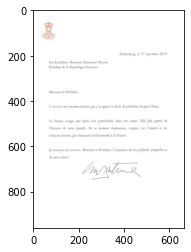

In [61]:
file = fs_photos.find_one()
image = file.read()

pil_img = Image.open(file)
plt.imshow(pil_img)
plt.show()

### Améliorations:

Afin d'optimiser la ram, nous pouvons scrapper les textes et les sauvegarder en continue sur MongoDB comme nous l'avions fait avec les photos. Nous pouvons aussi rajouter la possibilité de rentrer un texte au lieu des URLs statiques.